In [1]:
from src.datasets.document import *
from src.defaults import *
import sys
old_stdout = sys.stdout
load_nli = 'NLI-93'
# download_models_from_neptune(load_nli)
field = load_field(load_nli)
dataset_conf = {'dataset': 'reuters', 'max_num_sent': 60,"sent_tokenizer":"spacy","batch_size":64,"device":"cuda"}


In [2]:
data = document_dataset(dataset_conf,sentence_field = field)

In [3]:
for i in data.train_iter:
    print(i)
    break
print(len(data.train.examples))
print(len(data.test.examples))


[torchtext.data.batch.Batch of size 64 from REUTERS]
	[.text]:[torch.cuda.LongTensor of size 64x60x50 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 64x10 (GPU 0)]
6588
2553


In [4]:
model_conf = {'results_dir': 'results', 'device': 'cuda', 'dropout': 0.2, 'dataset': 'imdb', 'hidden_size': 300, "attention_layer_param":150,"freeze_encoder":True,"num_layers":1}

In [5]:
from src.model.nli_models import *
from src.model.novelty_models import *

def load_encoder(enc_data):
    if enc_data['options'].get("attention_layer_param",0)==0:
        model = bilstm_snli(enc_data["options"])
    elif enc_data['options'].get("r",0)==0:
        model = attn_bilstm_snli(enc_data["options"])
    else:
        model = struc_attn_snli(enc_data["options"])
    return model

nli_model_data = load_encoder_data(load_nli)
nli_model_data['options']["use_glove"] = False
encoder = load_encoder(nli_model_data).encoder
model_conf["encoder_dim"] = nli_model_data["options"]["hidden_size"]

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math


class Attention(nn.Module):
    def __init__(self, conf):
        super(Attention, self).__init__()
        self.Ws = nn.Linear(
            2 * conf["hidden_size"],
            conf["attention_layer_param"],
            bias=False,
        )
        self.Wa = nn.Linear(conf["attention_layer_param"], 1, bias=False)

    def forward(self, hid):
        opt = self.Ws(hid)
        opt = torch.tanh(opt)
        opt = self.Wa(opt)
        opt = F.softmax(opt, dim=1)
        return opt


class HAN_DOC(nn.Module):
    def __init__(self, conf, encoder):
        super(HAN_DOC, self).__init__()
        self.conf = conf
        self.encoder = encoder
        if self.conf["freeze_encoder"]:
            self.encoder.requires_grad_(False)

        self.translate = nn.Linear(
            2 * self.conf["encoder_dim"], self.conf["hidden_size"]
        )
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(conf["dropout"])
        self.template = nn.Parameter(torch.zeros((1)), requires_grad=True)
        self.lstm_layer = nn.LSTM(
            input_size=self.conf["hidden_size"],
            hidden_size=self.conf["hidden_size"],
            num_layers=self.conf["num_layers"],
            bidirectional=True,
        )
        self.attention = Attention(conf)

    def forward(self, inp):
        batch_size, num_sent, max_len = inp.shape
        x = inp.view(-1, max_len)

        x_padded_idx = x.sum(dim=1) != 0
        x_enc = []
        for sub_batch in x[x_padded_idx].split(64):
            x_enc.append(self.encoder(sub_batch, None))
        x_enc = torch.cat(x_enc, dim=0)

        x_enc_t = torch.zeros((batch_size * num_sent, x_enc.size(1))).to(
            self.template.device
        )

        x_enc_t[x_padded_idx] = x_enc
        x_enc_t = x_enc_t.view(batch_size, num_sent, -1)

        embedded = self.dropout(self.translate(x_enc_t))
        embedded = self.act(embedded)

        all_, (_, _) = self.lstm_layer(embedded)
        attn = self.attention(all_)

        cont = torch.bmm(attn.permute(0, 2, 1), all_)
        cont = cont.squeeze(1)
        return cont


class HAN_DOC_Classifier(nn.Module):
    def __init__(self,conf,encoder):
        super().__init__()
        self.conf = conf
        self.han_doc = HAN_DOC(conf,encoder)

        self.act = nn.ReLU()
        self.dropout = nn.Dropout(conf["dropout"])
        self.fc = nn.Linear(2 * conf["hidden_size"], 10)

    def forward(self, x0):
        x0_enc = self.han_doc(x0)
        cont = self.dropout(self.act(x0_enc))
        cont = self.fc(cont)
        return cont


In [7]:
model = HAN_DOC_Classifier(model_conf,encoder)

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1781261

In [9]:

from hyperdash import Experiment

sys.stdout = old_stdout

exp = Experiment("documentReuters",api_key_getter = get_hyperdash_api)
epochs = 15
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda")

model.to(device)


def train(model,dl,optimizer,criterion):
    model.train()
    iterator_size = len(dl)
    n_correct, n_total,running_loss = 0, 0,0

    for i, data in enumerate(dl, 0):
        inputs, labels = data.text,data.label

        batch_size = labels.shape[0]
        n_total += batch_size
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        # loss = criterion(outputs, labels.to(torch.float))
        labels = torch.argmax(labels,dim=1)
        loss = criterion(outputs, labels)

        predictions = torch.argmax(torch.softmax(outputs,dim=1),1)
        
        n_correct += (predictions == labels).sum().item()

        exp.metric('train loss',loss.item(),log=False)
        print(f"loss = {loss.item()}",end = '\r')
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    acc = 100*n_correct/n_total
    exp.metric('train running loss',running_loss/iterator_size,log=False)
    exp.metric('Train Acc',acc,log=False)
    print('Loss: {}'.format(running_loss/iterator_size))
    print('ACC: {}'.format(acc))
    print("-------------")


def validate(model,dl,criterion):

    iterator_size = len(dl)
    n_correct, n_total, running_loss = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dl, 0):
            inputs, labels = data.text,data.label
            batch_size = labels.shape[0]
            # forward 
            outputs = model(inputs)
            # loss = criterion(outputs, labels.to(torch.float))
            loss = criterion(outputs, torch.argmax(labels,dim=1))
            predictions = torch.argmax(torch.sigmoid(outputs),1)
            n_correct += (predictions.cpu() == torch.argmax(labels.cpu(),1)).sum().item()
            n_total += batch_size
            
            exp.metric('val loss',loss.item(),log=False)
            print(f"loss = {loss.item()}",end = '\r')
            running_loss += loss.item()
        
        
        acc = 100*n_correct/n_total
        exp.metric('val running loss',running_loss/iterator_size, log=False)
        exp.metric('Val Acc',acc,log=False)
        print('Val Loss: {}'.format(running_loss/iterator_size))
        print('Val acc: {}'.format(acc))
        print("-------------")

try:

    # loop over the dataset multiple times
    for epoch in range(epochs):
        train(model,data.train_iter,optimizer,criterion)
        validate(model,data.test_iter,criterion)
    validate(model,data.test_iter,criterion)
    exp.end()
    print('Finished Training')
except KeyboardInterrupt:
    validate(model,data.test_iter,criterion)
    exp.end()

Loss: 1.702254868248134
ACC: 43.169398907103826
-------------


ZeroDivisionError: division by zero

In [10]:
model.eval()
all_opts = torch.empty((0,8))
all_lab = torch.empty((0,8))
with torch.no_grad():
    for i, d in enumerate(data.test_iter, 0):
        inputs, labels = d.text,d.label
        outputs = torch.sigmoid(model(inputs))
        all_opts = torch.cat([all_opts,outputs.cpu()],dim=0)
        all_lab = torch.cat([all_lab,labels.cpu()],dim=0)


In [11]:
from sklearn.metrics import accuracy_score,classification_report

In [12]:
sys.stdout = old_stdout
print(classification_report(torch.argmax(all_opts,1),torch.argmax(all_lab,1)))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       755
           1       0.48      0.29      0.36       268
           2       0.96      0.94      0.95      1105
           3       0.13      0.24      0.17        71
           4       0.01      1.00      0.02         1
           5       0.64      0.33      0.44       290
           6       0.00      0.00      0.00         0
           7       0.03      0.60      0.05         5

    accuracy                           0.75      2495
   macro avg       0.39      0.53      0.36      2495
weighted avg       0.83      0.75      0.78      2495



In [14]:
print(len(data.train.examples))
print(len(data.test.examples))

6588
2553


In [20]:
inp = torch.randint(1,1000,(64,60,50)).to(torch.long)
model(inp).shape

torch.Size([64, 8])

In [22]:
torch.argmax(all_opts, dim=1)

tensor([80, 80, 80,  ..., 80, 80, 80])

In [33]:
torch.argmax(all_lab, dim=0)

tensor([  10,  124,    0,   34,  624,   88,   41,  370,    9,  195,   32,   47,
          37,  191,   40,    0,   25,   35,   11,    1,    6,   50,   59,   67,
         339,  468,   41,   25,    0,  398,  656,  670,  416,  572,    7,   85,
         618,  618,   32,  114,   27,    1,   45,  204,   61,   25,   53,   81,
         434,    1,    5,   26,   81,    5,  474,   80,  320,  119,  699,   46,
         468,  148,   46,  477,   49,   11,   94,    0,  106,  418,  297,   45,
          52,   85,   56,   51,   58,    8, 1128,   50,    6,  163,   57,  367,
          63,   47,    0,  562,  490,  118])

In [1]:
from src.datasets.temp import ReutersParser
import glob
documents = []
rp = ReutersParser()
for sgml_path in glob.glob(".data/reuters/*.sgm"):
    for doc in rp.parse_sgml(str(sgml_path)):
        doc["filename"] = sgml_path
        documents.append(doc)


In [2]:
from src.datasets.temp import ReutersCorpus

reuters = ReutersCorpus(documents)


In [5]:
import pickle
pickle_path = "temp/corpus.pkl"
# os.makedirs('temp')
with open(str(pickle_path), "wb") as f:
    pickle.dump(reuters, f)

In [54]:
reuters = pickle.load(open(pickle_path, "rb"))


In [41]:
top_ten_ids, top_ten_names = reuters.top_n(n=10)


In [6]:
df, top_ten_ids, train_labels, test_labels = reuters.build_dataframe()


In [7]:
df

,modapte,category,label,date,title,dateline,body,newid,wd_name
0,train,[earn],[1],1987-03-26 12:13:39,ISLAND TELEPHONE SHARE SPLIT APPROVED,"CHARLOTTETOWN, Prince Edward Island, March...",<Island\nTelephone Co Ltd> said the previously...,10002,Thursday
1,train,"[trade, acq]","[12, 0]",1987-03-26 12:19:18,U.K. GROWING IMPATIENT WITH JAPAN - THATCHER,"LONDON, March 26 -",Prime Minister Margaret Thatcher said\nthe U.K...,10005,Thursday
2,train,[earn],[1],1987-03-26 12:21:42,QUESTECH INC <QTEC> YEAR NET,"MCLEAN, Va., March 26 - \n","Shr loss nil vs profit 19 cts\n Net loss 3,...",10008,Thursday
3,train,"[crude, nat-gas]","[3, 4]",1987-03-26 12:26:06,CANADA OIL EXPORTS RISE 20 PCT IN 1986,"OTTAWA, March 26 -",Canadian oil exports rose 20 pct in 1986\nover...,10011,Thursday
4,train,"[coffee, cocoa, sugar]","[24, 25, 23]",1987-03-26 12:27:45,"COFFEE, SUGAR AND COCOA EXCHANGE NAMES CHAIRMAN","NEW YORK, March 26 -","The New York Coffee, Sugar and Cocoa\nExchange...",10014,Thursday
...,...,...,...,...,...,...,...,...,...
10784,test,[acq],[0],1987-06-02 09:18:40,CENTEL <CNT> COMPLETES SALE,"CHICAGO, June 2 -",Centel Corp said it completed the sale of\nits...,17981,Tuesday
10785,test,"[cocoa, acq]","[25, 0]",1987-06-02 09:24:57,"W.R. GRACE <GRA>, BERISFORD PLAN COCOA VENTURE","NEW YORK, June 2 -",W.R. Grace and Co said it has agreed to\ncombi...,17984,Tuesday
10786,test,[acq],[0],1987-06-02 09:41:32,CSR SAYS IT IS PROCEEDING WITH OFFER FOR MONIER,"SYDNEY, June 2 -",CSR Ltd <CSRA.S> intends to proceed with\nits ...,17986,Tuesday
10787,test,[earn],[1],1987-06-02 09:42:15,COMP-U-CARD INTERNATIONAL INC <CUCD.O> 1ST QTR,"STAMFORD, Conn., June 2 -",Periods ended April 30\n Shr 18 cts vs 15 c...,17988,Tuesday


In [8]:
train, test = reuters.split_modapte()


In [10]:
import numpy as np
number_of_samples = reuters.number_of_samples
number_of_classes = reuters.number_of_classes
number_of_samples_per_class = int(np.average([tc for tc in reuters.topic_counts.values() if tc > 1]))
number_of_words_per_sample = int(np.median([len(d["text"].split()) for d in reuters.docs]))
samples_to_words_per_sample_ratio = int(number_of_samples / number_of_words_per_sample)

In [11]:
nchars = 52
print("Number of samples:".ljust(nchars), reuters.number_of_samples)
print("Number of classes:".ljust(nchars), reuters.number_of_classes)
print("Number of samples per class:".ljust(nchars), number_of_samples_per_class)
print("Number of words per sample:".ljust(nchars), number_of_words_per_sample)
print("Number of samples/number of words per sample ratio:".ljust(nchars), samples_to_words_per_sample_ratio)

Number of samples:                                   10789
Number of classes:                                   119
Number of samples per class:                         148
Number of words per sample:                          89
Number of samples/number of words per sample ratio:  121


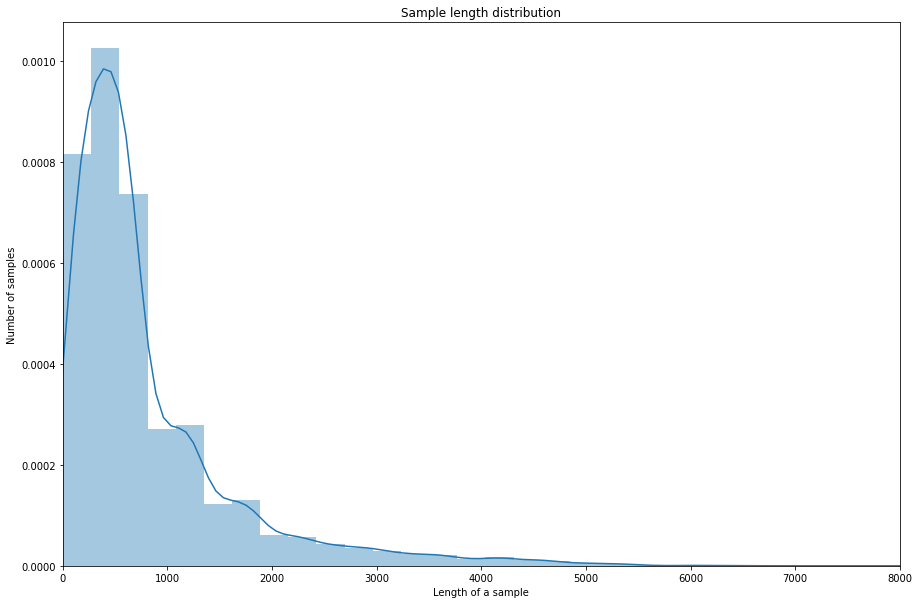

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot([len(d["text"]) for d in reuters.docs], kde=True, ax=ax)
ax.set_title('Sample length distribution')
ax.set_xlabel('Length of a sample')
ax.set_xlim(0, 8000)
_ = ax.set_ylabel('Number of samples')

In [15]:
from sklearn.feature_extraction.text import CountVectorizer


In [16]:
kwargs = {
        'ngram_range': (1, 1),
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',  # Split text into word tokens.
}
vectorizer = CountVectorizer(**kwargs)
vectorized_texts = vectorizer.fit_transform(reuters.texts)
all_ngrams = list(vectorizer.get_feature_names())
all_counts = vectorized_texts.sum(axis=0).tolist()[0]
all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
    zip(all_counts, all_ngrams), reverse=True)])

num_ngrams=50
ngrams = list(all_ngrams)[:num_ngrams]
counts = list(all_counts)[:num_ngrams]
idx = np.arange(num_ngrams)

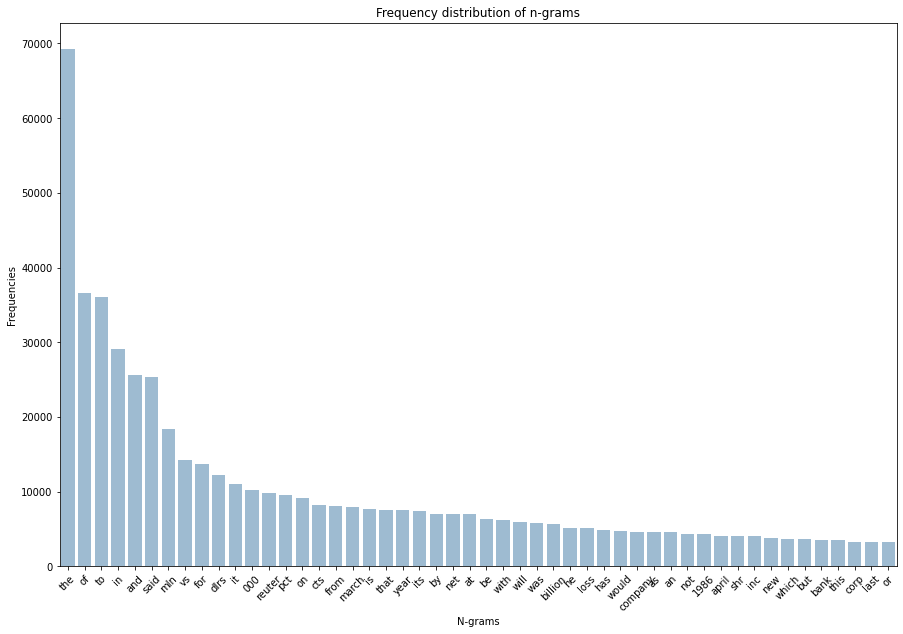

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=ngrams, y=counts, ax=ax, color="#95BCD9")
ax.set_title('Sample length distribution')
plt.xlabel('N-grams')
_ = plt.ylabel('Frequencies')
_ = plt.title('Frequency distribution of n-grams')
_ = plt.xticks(idx, ngrams, rotation=45)


In [18]:
top_ten_ids, top_ten_names = reuters.top_n(n=10)


In [19]:
train_docs, test_docs = reuters.split_modapte()


In [22]:
docs = train_docs + test_docs
train_labels = reuters.get_single_label(train_docs, set(top_ten_ids))
test_labels = reuters.get_single_label(test_docs, set(top_ten_ids))

In [37]:
topics=reuters.topics

labels = train_labels + test_labels
label_lookup = {}
num = 0
for label in sorted(labels):
    if label not in label_lookup:
        label_lookup[label] = num
        num += 1

topic_lookup = {v-1: k for k, v in topics.items()}
orig_labels = [topic_lookup[l] for l in labels]

labels = [label_lookup[l] for l in labels]
train_labels = [label_lookup[l] for l in train_labels]
test_labels = [label_lookup[l] for l in test_labels]
top_ten_ids = [label_lookup[tid] for tid in top_ten_ids]

# build dataframe
df = pd.DataFrame()
df["modapte"] = [d["modapte"] for d in docs]
df["category"] = orig_labels
df["label"] = train_labels + test_labels
df["date"] = [d["date"] for d in docs]
df["title"] = [d["title"] for d in docs]
df["dateline"] = [d["dateline"] for d in docs]
df["body"] = [d["body"] for d in docs]
df["newid"] = [d["attrs"]["NEWID"] for d in docs]
df["date"] = pd.to_datetime(
    df.date.str.split(".").apply(lambda x: x[0].lstrip()),
    format="%d-%b-%Y %H:%M:%S",
)
df["wd_name"] = df.date.dt.day_name()


In [36]:
import pandas as pd

In [38]:
df

,modapte,category,label,date,title,dateline,body,newid,wd_name
0,train,earn,1,1987-03-26 12:13:39,ISLAND TELEPHONE SHARE SPLIT APPROVED,"CHARLOTTETOWN, Prince Edward Island, March...",<Island\nTelephone Co Ltd> said the previously...,10002,Thursday
1,train,acq,0,1987-03-26 12:19:18,U.K. GROWING IMPATIENT WITH JAPAN - THATCHER,"LONDON, March 26 -",Prime Minister Margaret Thatcher said\nthe U.K...,10005,Thursday
2,train,earn,1,1987-03-26 12:21:42,QUESTECH INC <QTEC> YEAR NET,"MCLEAN, Va., March 26 - \n","Shr loss nil vs profit 19 cts\n Net loss 3,...",10008,Thursday
3,train,crude,3,1987-03-26 12:26:06,CANADA OIL EXPORTS RISE 20 PCT IN 1986,"OTTAWA, March 26 -",Canadian oil exports rose 20 pct in 1986\nover...,10011,Thursday
4,train,veg-oil,20,1987-03-26 12:27:45,"COFFEE, SUGAR AND COCOA EXCHANGE NAMES CHAIRMAN","NEW YORK, March 26 -","The New York Coffee, Sugar and Cocoa\nExchange...",10014,Thursday
...,...,...,...,...,...,...,...,...,...
10784,test,acq,0,1987-06-02 09:18:40,CENTEL <CNT> COMPLETES SALE,"CHICAGO, June 2 -",Centel Corp said it completed the sale of\nits...,17981,Tuesday
10785,test,acq,0,1987-06-02 09:24:57,"W.R. GRACE <GRA>, BERISFORD PLAN COCOA VENTURE","NEW YORK, June 2 -",W.R. Grace and Co said it has agreed to\ncombi...,17984,Tuesday
10786,test,acq,0,1987-06-02 09:41:32,CSR SAYS IT IS PROCEEDING WITH OFFER FOR MONIER,"SYDNEY, June 2 -",CSR Ltd <CSRA.S> intends to proceed with\nits ...,17986,Tuesday
10787,test,earn,1,1987-06-02 09:42:15,COMP-U-CARD INTERNATIONAL INC <CUCD.O> 1ST QTR,"STAMFORD, Conn., June 2 -",Periods ended April 30\n Shr 18 cts vs 15 c...,17988,Tuesday


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer

train_docs, test_docs = reuters.split_modapte()
print(len(train_docs), len(test_docs))

train = [d["text"] for d in train_docs]
train_labels = reuters.get_labels(train_docs)
y_train = MultiLabelBinarizer().fit_transform(train_labels)

test = [d["text"] for d in test_docs]
test_labels = reuters.get_labels(test_docs)
y_test = MultiLabelBinarizer().fit_transform(test_labels)

7770 3019


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [45]:

vectorizer = TfidfVectorizer()
vectorizer.fit(train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [46]:
X_train = vectorizer.transform(train)
X_test = vectorizer.transform(test)

In [47]:
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

In [48]:
from sklearn.linear_model import LogisticRegression
# model = OneVsRestClassifier(LogisticRegression(C=100, solver="liblinear", multi_class="ovr"))
model = OneVsRestClassifier(LogisticRegression(solver="liblinear", multi_class="ovr"))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids))


              precision    recall  f1-score   support

        earn       0.99      0.97      0.98      1087
         acq       0.98      0.92      0.95       719
    money-fx       0.78      0.51      0.62       179
       grain       0.99      0.60      0.75       149
       crude       0.96      0.57      0.72       189
       trade       0.93      0.54      0.68       117
    interest       0.91      0.47      0.62       131
        ship       1.00      0.13      0.24        89
       wheat       0.97      0.51      0.67        71
        corn       0.95      0.32      0.48        56

   micro avg       0.97      0.79      0.87      2787
   macro avg       0.95      0.56      0.67      2787
weighted avg       0.97      0.79      0.85      2787
 samples avg       0.70      0.69      0.69      2787



In [55]:
import itertools
classes = df['category'].values

In [56]:
np.unique(classes,return_counts=True)

(array(['acq', 'alum', 'barley', 'bfr', 'bop', 'carcass', 'castor-oil',
        'castorseed', 'cocoa', 'coconut', 'coffee', 'copper', 'corn',
        'cotton', 'cottonseed', 'cpi', 'crude', 'dfl', 'dlr', 'earn',
        'f-cattle', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut',
        'heat', 'hog', 'income', 'interest', 'ipi', 'iron-steel', 'jobs',
        'lead', 'lei', 'lit', 'livestock', 'meal-feed', 'money-fx',
        'money-supply', 'nat-gas', 'nickel', 'oat', 'oilseed', 'orange',
        'palm-oil', 'pet-chem', 'platinum', 'propane', 'rape-oil',
        'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'ship',
        'silver', 'sorghum', 'soy-oil', 'soybean', 'strategic-metal',
        'sugar', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen',
        'zinc'], dtype=object),
 array([2334,   12,   17,    4,   11,   15,    1,    4,  100,    3,   32,
          39,  194,   25,   17,   23,  525,    2,    7, 3943,   27,   41,
          12,   20,  112,  156,    7,    1